# Libraries

In [3]:
import cv2 as cv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
from pathlib import Path

from scipy.ndimage import gaussian_filter

In [4]:
features_path = Path.cwd()
notebooks_path = features_path.parent
repo_path = notebooks_path.parent
os.chdir(str(features_path))
#print current working directory
print(notebooks_path)

/home/ricardino/Documents/MAIA/tercer_semestre/CAD/Projecte/Machine_Learning/notebooks


# Classes and functions

In [5]:
class path_label():
    """Class to access paths and labels from csv
    """
    def __init__(self, meta=pd.read_csv(str(repo_path) + '/data/meta_info.csv', sep='\t'), classif='binary', set_name='train') -> None:
        meta = meta.loc[meta['classif'] == classif] #Filter by classif
        meta = meta.loc[meta['set'] == set_name] #Filter by set
        self.paths = list(meta.path)
        self. labels = np.array(meta.label)

In [6]:
def RGB_visual(im_path):
    """Show one image in RGB and its channels

    Args:
        im_path (_type_): _description_
    """
    im_BGR = cv.imread(im_path)
    im = cv.cvtColor(im_BGR, cv.COLOR_BGR2RGB)
    fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(15,15))
    axs[0].imshow(im)
    axs[1].imshow(im[:,:,0], cmap='gray')
    axs[2].imshow(im[:,:,1], cmap='gray')
    axs[3].imshow(im[:,:,2], cmap='gray')

In [7]:
#Get diagonals
def get_diagonals(im):
    """Returns the main diagonals of a given image in grayscale

    Args:
        im (array): image

    Returns:
        1D arrays: diagonals
    """
    diag1 = im.diagonal()
    diag2 = np.fliplr(im).diagonal()
    diag3 = np.flipud(im).diagonal()
    diag4 = np.flipud(np.fliplr(im)).diagonal()
    
    return diag1, diag2, diag3, diag4

In [8]:
def diag_coord(diag):
    """Gives the first and last diagonal value of the image with gradient diferent than zero. 

    Args:
        diag (1D array): Diagonal of image

    Returns:
        2 int: position on the diagonal of the 1st and last non-zero value
    """
    diag_grad = np.gradient(diag)
    pos = np.argwhere(diag_grad)
    p_coord = int(pos[0])+10
    
    return p_coord

In [9]:
def no_FOV_range(im_path):
    """Get x and y coordinates of the subimage without FOV, when needed. If no FOV is detected, full image coordinates are given

    Args:
        im_path (str): image path

    Returns:
        4 int: x and y coodinates of subimag
    """
    im_BGR = cv.imread(im_path)
    im_g = cv.cvtColor(im_BGR, cv.COLOR_BGR2GRAY)
    shape_g = im_g.shape
    corners = [im_g[0,0], im_g[0,-1], im_g[-1,0], im_g[-1,-1]]

    criteria = all(flag<=50 for flag in corners) #Check 4 corners

    if criteria:
        _,im_otsu = cv.threshold(im_g,0,255,type=cv.THRESH_BINARY + cv.THRESH_OTSU)
        diag1, diag2, diag3, diag4 = get_diagonals(im_otsu)
        
        p1_coord = diag_coord(diag1)
        p2_coord = diag_coord(diag2)
        p3_coord = diag_coord(diag3)
        p4_coord = diag_coord(diag4)
        
        p1 = [p1_coord, p1_coord]
        p2 = [p2_coord, shape_g[1]-p2_coord]
        p3 = [shape_g[0] - p3_coord, p3_coord]
        p4 = [shape_g[0] - p4_coord, shape_g[1] - p4_coord]
        #Rectangle coordinates
        c1 = [np.max([p1[0], p2[0]]), np.max([p1[1],p3[1]])]
        c2 = [np.max([p1[0], p2[0]]), np.min([p2[1],p4[1]])]
        c3 = [np.min([p3[0], p4[0]]), np.max([p1[1],p3[1]])]
        c4 = [np.min([p3[0], p4[0]]), np.min([p2[1],p4[1]])]
        
        x1 = c1[0] ; x2 = c3[0] ; y1 = c1[1] ; y2 = c2[1]
        
        if x1>x2 or y1>y2:
            x1 = 0 ; x2 = shape_g[0] ; y1 = 0 ; y2 = shape_g[1]
        
    else:
        x1 = 0 ; x2 = shape_g[0] ; y1 = 0 ; y2 = shape_g[1]
    
    return x1, x2, y1, y2
        

# Removing FOV

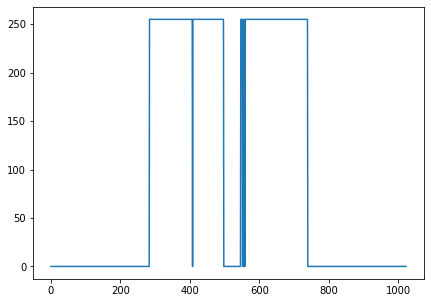

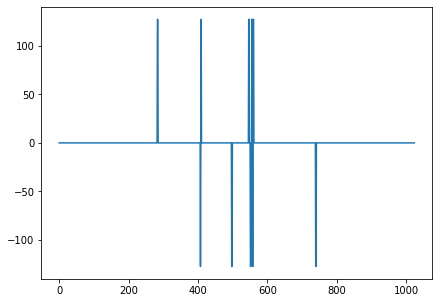

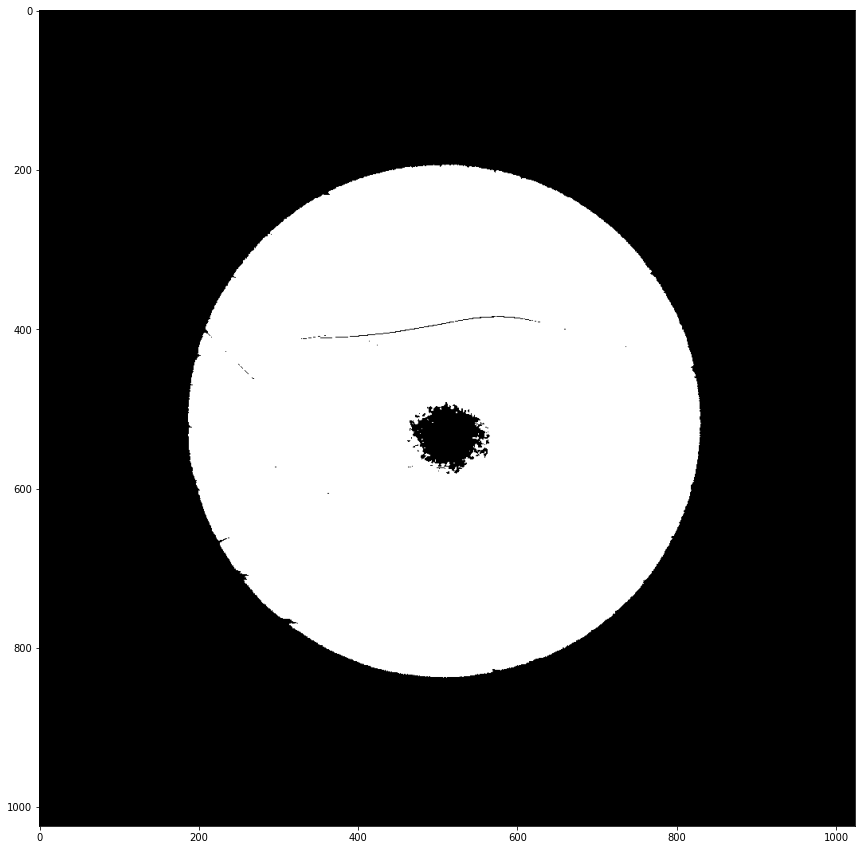

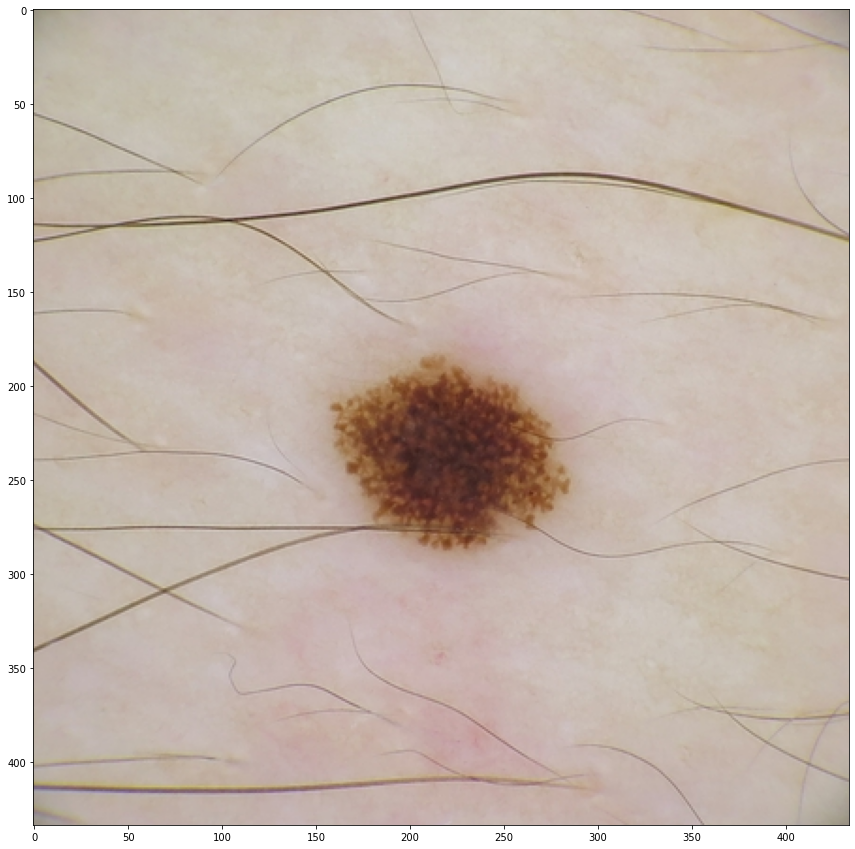

In [51]:
#Settings
set_name = 'train'

meta = pd.read_csv(str(repo_path) + '/data/meta_info.csv', sep='\t') #TEST SET
classif = 'binary'
paths = path_label(meta, classif, set_name).paths #get paths

im_path = str(repo_path) + '/' + paths[7695] #define absolute path

x1, x2, y1, y2 = no_FOV_range(im_path) #get coordinates

im_RGB = cv.cvtColor(cv.imread(im_path), cv.COLOR_BGR2RGB)
im_gray = cv.cvtColor(cv.imread(im_path), cv.COLOR_BGR2GRAY)
new_im = im_RGB[x1:x2, y1:y2, :] #subimage with new coordinates
_,im_otsu = cv.threshold(im_gray,0,255,type=cv.THRESH_BINARY + cv.THRESH_OTSU)
diag1, diag2, diag3, diag4 = get_diagonals(im_otsu)
diag_grad = np.gradient(diag1)
plt.figure(figsize=(7,5))
plt.plot(diag1)
plt.figure(figsize=(7,5))
plt.plot(diag_grad)


plt.figure(figsize=(15,15))
plt.imshow(im_otsu, cmap='gray')
plt.show()

plt.figure(figsize=(15,15))
plt.imshow(new_im)

# Saving in meta file

In [11]:
# meta = pd.read_csv(str(repo_path) + '/data/meta_test.csv', sep='\t') #Rad meta
# x1 = np.zeros(shape=(meta.__len__(),))
# x2 = np.zeros_like(x1)
# y1 = np.zeros_like(x1)
# y2 = np.zeros_like(x1)
# for i, im_path in enumerate(tqdm(meta.path)):
#     x1[i], x2[i], y1[i], y2[i] = no_FOV_range(str(repo_path) + '/' + im_path)

# meta['FOV_x1'] = x1 #Save as new column
# meta['FOV_x2'] = x2 #Save as new column
# meta['FOV_y1'] = y1 #Save as new column
# meta['FOV_y2'] = y2 #Save as new column
# meta.to_csv(str(repo_path) + '/data/meta_test.csv', sep='\t', index=False) # Save as new csv